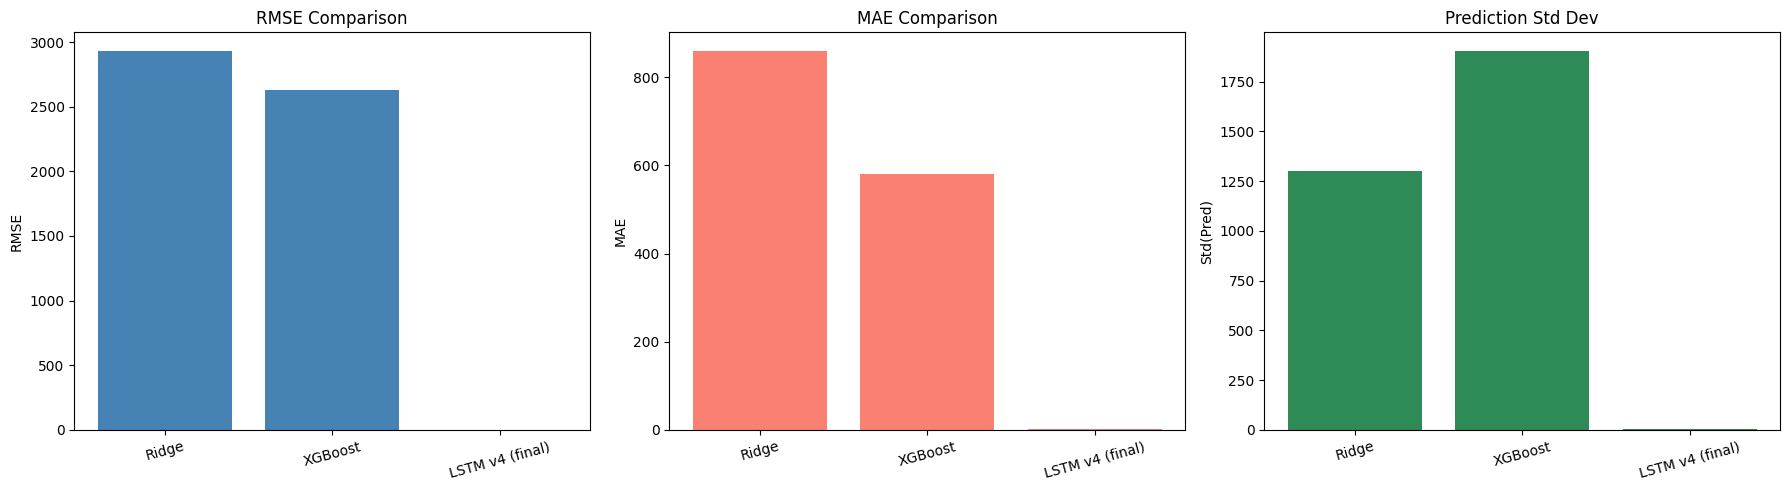

In [16]:
# compare_models.ipynb (Python 버전 전체)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
import torch
import torch.nn as nn

# 경로 설정
office_data_path = "../data/processed/office_data.parquet"
lstm_pred_path = "../models/lstm_predictions.csv"
ridge_model_path = "../models/ridge_model.pkl"
xgb_model_path = "../models/xgboost_model.json"
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Feature 목록 (Ridge & XGBoost에서 사용된 feature)
features = ['square_feet', 'year_built', 'air_temperature', 'dew_temperature', 'hour', 'weekday']

# 1. Ridge & XGBoost 공통 데이터 로딩 및 분할
office_df = pd.read_parquet(office_data_path)
X_full = office_df[features].values.astype(np.float32)
y_full = office_df["meter_reading"].values.astype(np.float32)
split_idx = int(len(X_full) * 0.8)
X_input = X_full[split_idx:]
y_true_office = y_full[split_idx:]

# --- Ridge 평가 ---
ridge_model = joblib.load(ridge_model_path)
X_input_df = pd.DataFrame(X_input, columns=features)
ridge_pred = ridge_model.predict(X_input_df)
rmse_ridge = np.sqrt(np.mean((y_true_office - ridge_pred) ** 2))
mae_ridge = np.mean(np.abs(y_true_office - ridge_pred))
std_ridge = np.std(ridge_pred)

# --- XGBoost 평가 ---
xgb_model = xgb.Booster()
xgb_model.load_model(xgb_model_path)
X_input_df = pd.DataFrame(X_input, columns=features)
dmatrix = xgb.DMatrix(X_input_df)
xgb_pred = xgb_model.predict(dmatrix)
rmse_xgb = np.sqrt(np.mean((y_true_office - xgb_pred) ** 2))
mae_xgb = np.mean(np.abs(y_true_office - xgb_pred))
std_xgb = np.std(xgb_pred)

# 2. LSTM 결과 로딩
lstm_df = pd.read_csv(lstm_pred_path)
y_true_lstm = lstm_df["y_true"].values
y_pred_lstm = lstm_df["y_pred"].values
rmse_lstm = np.sqrt(np.mean((y_true_lstm - y_pred_lstm) ** 2))
mae_lstm = np.mean(np.abs(y_true_lstm - y_pred_lstm))
std_lstm = np.std(y_pred_lstm)

# 3. 성능 비교표 생성
comparison_df = pd.DataFrame([
    {"Model": "Ridge", "RMSE": rmse_ridge, "MAE": mae_ridge, "Std(Pred)": std_ridge},
    {"Model": "XGBoost", "RMSE": rmse_xgb, "MAE": mae_xgb, "Std(Pred)": std_xgb},
    {"Model": "LSTM v4 (final)", "RMSE": rmse_lstm, "MAE": mae_lstm, "Std(Pred)": std_lstm},
])

# 저장
comparison_df.to_csv(f"{results_dir}/model_comparison.csv", index=False)

# 4. 시각화
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(comparison_df['Model'], comparison_df['RMSE'], color='steelblue')
ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE")
ax[0].tick_params(axis='x', rotation=15)

ax[1].bar(comparison_df['Model'], comparison_df['MAE'], color='salmon')
ax[1].set_title("MAE Comparison")
ax[1].set_ylabel("MAE")
ax[1].tick_params(axis='x', rotation=15)

ax[2].bar(comparison_df['Model'], comparison_df['Std(Pred)'], color='seagreen')
ax[2].set_title("Prediction Std Dev")
ax[2].set_ylabel("Std(Pred)")
ax[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(f"{results_dir}/model_comparison_plot.png")
plt.show()
